In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df = pd.read_csv('/chatgpt_daily_tweets.csv')


In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['lang'] == 'en']

In [ ]:
df.shape

(20114, 23)

In [ ]:
max_len = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_len)

In [ ]:
from textblob import TextBlob
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [ ]:
df['sentiment_polarity'] = df['cleaned_text'].apply(get_sentiment_polarity)
df['sentiment'] = np.where(df['sentiment_polarity'] >= 0, 'positive', 'negative')

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['sentiment'])
labels = labels.reshape(-1, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(len(word_index) + 1, 128, input_length=max_len)(input_layer)
x = GlobalMaxPooling1D()(embedding_layer)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/10
503/503 [==============================] - 21s 39ms/step - loss: 0.3953 - accuracy: 0.8544 - val_loss: 0.2514 - val_accuracy: 0.9060
Epoch 2/10
503/503 [==============================] - 19s 38ms/step - loss: 0.1629 - accuracy: 0.9434 - val_loss: 0.1391 - val_accuracy: 0.9515
Epoch 3/10
503/503 [==============================] - 20s 39ms/step - loss: 0.0653 - accuracy: 0.9786 - val_loss: 0.1288 - val_accuracy: 0.9575
Epoch 4/10
503/503 [==============================] - 20s 39ms/step - loss: 0.0244 - accuracy: 0.9937 - val_loss: 0.1391 - val_accuracy: 0.9565
Epoch 5/10
503/503 [==============================] - 20s 39ms/step - loss: 0.0093 - accuracy: 0.9984 - val_loss: 0.1545 - val_accuracy: 0.9543
Epoch 6/10
503/503 [==============================] - 18s 37ms/step - loss: 0.0042 - accuracy: 0.9998 - val_loss: 0.1694 - val_accuracy: 0.9530


In [ ]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

126/126 [==============================] - 0s 2ms/step - loss: 0.1694 - accuracy: 0.9530
Test loss: 0.1693517416715622
Test accuracy: 0.9530201554298401


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
import itertools

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

126/126 [==============================] - 1s 6ms/step


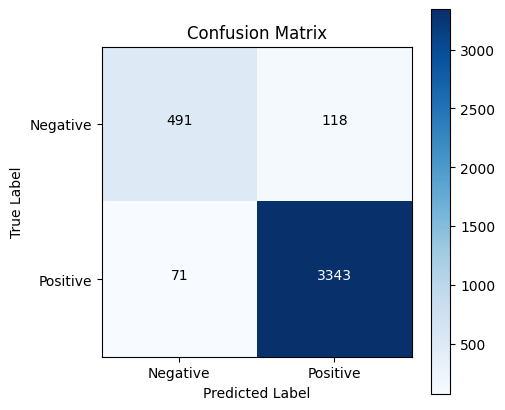

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

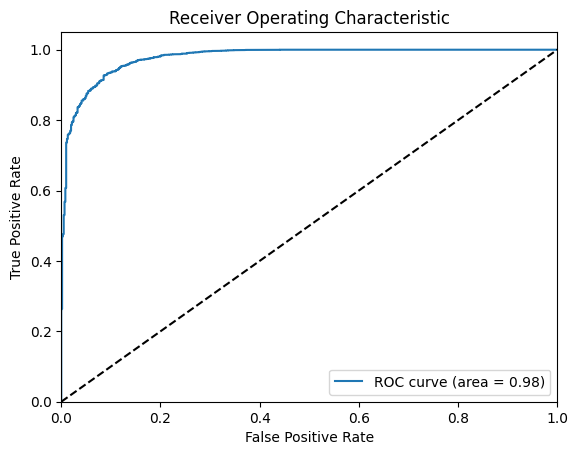

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


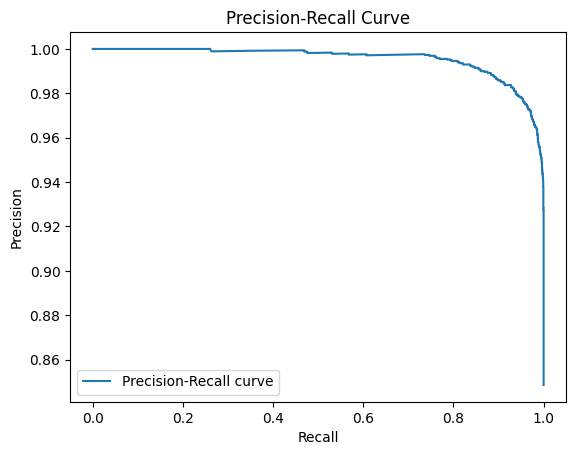

In [ ]:
# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

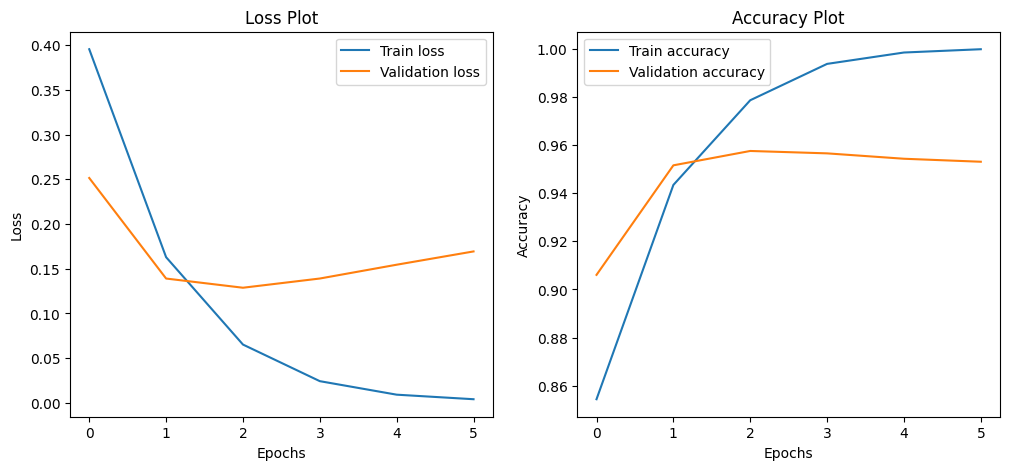

In [ ]:
# Loss and accuracy plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.87      0.81      0.84       609
    Positive       0.97      0.98      0.97      3414

    accuracy                           0.95      4023
   macro avg       0.92      0.89      0.91      4023
weighted avg       0.95      0.95      0.95      4023

